In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':'18OnKZzKOkb3rZv_mgsvy6DP_z0bRVWHU'}) 
downloaded.GetContentFile('train.csv')

In [0]:
# For test file
download1 = drive.CreateFile({'id':'1rCir71bmCEDoEB9-4gXA8ZJxGjvx0DSk'})
downloaded.GetContentFile('test.csv')

In [0]:
# For Submission file
download2 = drive.CreateFile({'id':'1Mmx9ADQGtCzG93YwCil9idp0lPofDXdC'})
downloaded.GetContentFile('submission.csv')

In [203]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [204]:
!pip install scikit-plot

In [1]:
# importing the libaries

import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , KFold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report , confusion_matrix , f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , roc_curve , accuracy_score , precision_score , recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import folium 
from folium import plugins

#from spellchecker import SpellChecker

Using TensorFlow backend.


In [2]:
# Load the train and test dataset

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
new_train = train
new_train['keyword'].fillna("No keyword",inplace=True)
new_train.isnull().sum()

id             0
keyword        0
location    2533
text           0
target         0
dtype: int64

In [7]:
# drop the location column both from train and test part

# train.drop(['location'] , axis = 1 , inplace = True)
# test.drop(['location'] , axis = 1 , inplace = True)

In [8]:
train.shape

(7613, 5)

## EDA

Text(0, 0.5, 'Number of samples')

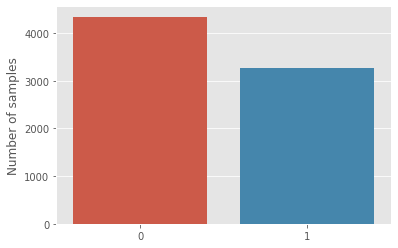

In [9]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('Number of samples')

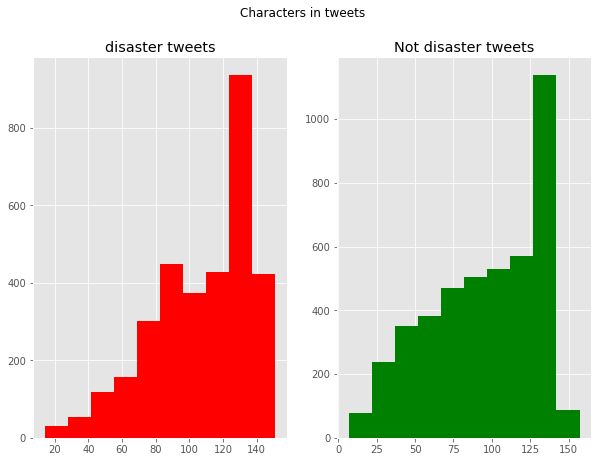

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

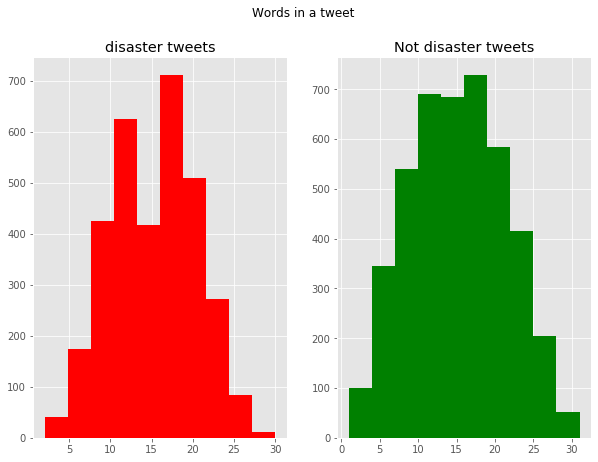

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

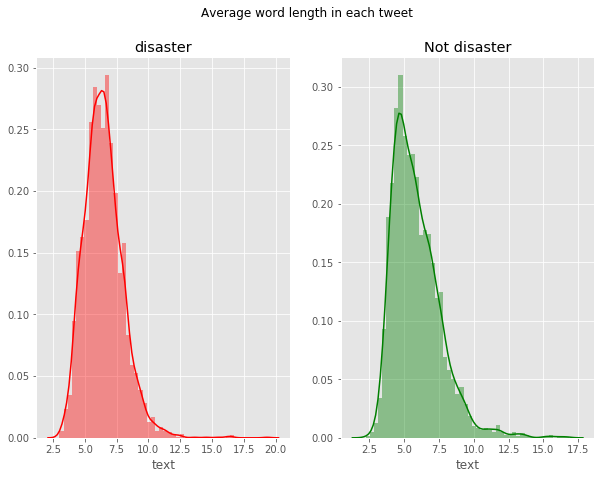

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,7))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [217]:
# Tweets per location

cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets depending on location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [218]:
#Number of tweets depending on location per class

train1_df = train[train["target"]==1]
train0_df = train[train["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of real disaster tweets",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of unreal disaster tweets",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets depending on location per class')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

#### Visualize per location using map

In [219]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


df = train['location'].value_counts()[:20,]
df = pd.DataFrame(df)
df = df.reset_index()
df.columns = ['location', 'counts'] 
geolocator = Nominatim(user_agent="specify_your_app_name_here")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
dictt_latitude = {}
dictt_longitude = {}
for i in df['location'].values:
    print(i)
    location = geocode(i)
    dictt_latitude[i] = location.latitude
    dictt_longitude[i] = location.longitude
df['latitude']= df['location'].map(dictt_latitude)
df['longitude'] = df['location'].map(dictt_longitude)

USA
New York
United States
London
Canada
Nigeria
UK
Los Angeles, CA
India
Mumbai
Washington, DC
Kenya
Worldwide
Chicago, IL
Australia
California
Everywhere
New York, NY
California, USA
United Kingdom


In [220]:
map1 = folium.Map(location=[10.0, 10.0], tiles='CartoDB dark_matter', zoom_start=2.3)
markers = []
for i, row in df.iterrows():
    loss = row['counts']
    if row['counts'] > 0:
        count = row['counts']*0.4
    folium.CircleMarker([float(row['latitude']), float(row['longitude'])], radius=float(count), color='#ef4f61', fill=True).add_to(map1)
map1

It is clear that most of the tweets from america region.

#### Common Stopwords in tweets

In [0]:
def create_corpus(target):
    corpus =[]
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

In [0]:
corpus = create_corpus(1)

In [0]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top = sorted(dic.items(), key = lambda x:x[1] , reverse = True)[:10] 

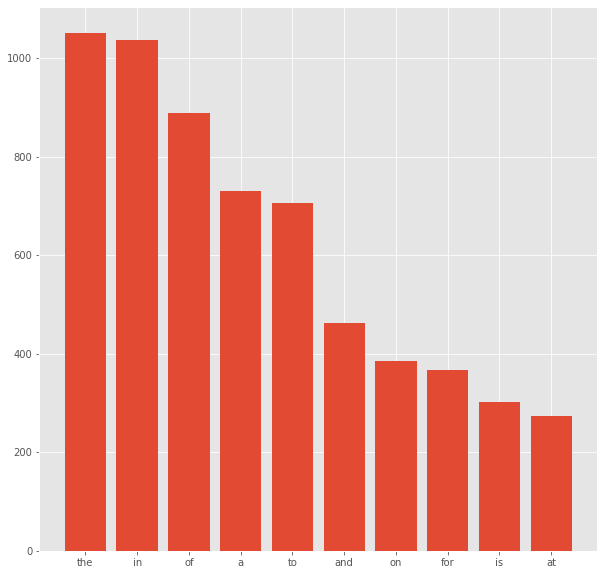

In [224]:
x , y = zip(*top)
plt.figure(figsize = (10 , 10))
plt.bar(x , y);

#### Analyzing Punctuations

<BarContainer object of 18 artists>

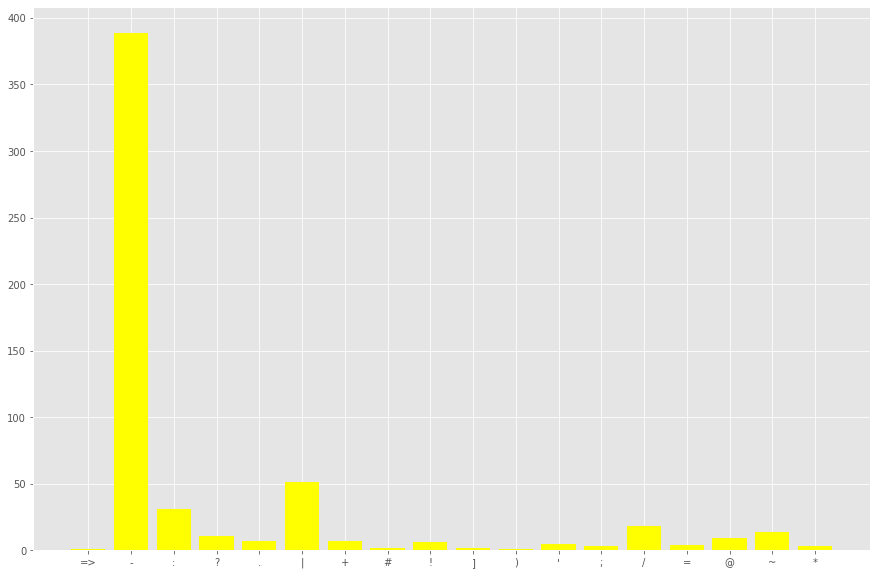

In [225]:
plt.figure(figsize=(15 , 10))

corpus = create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y , color = 'yellow')

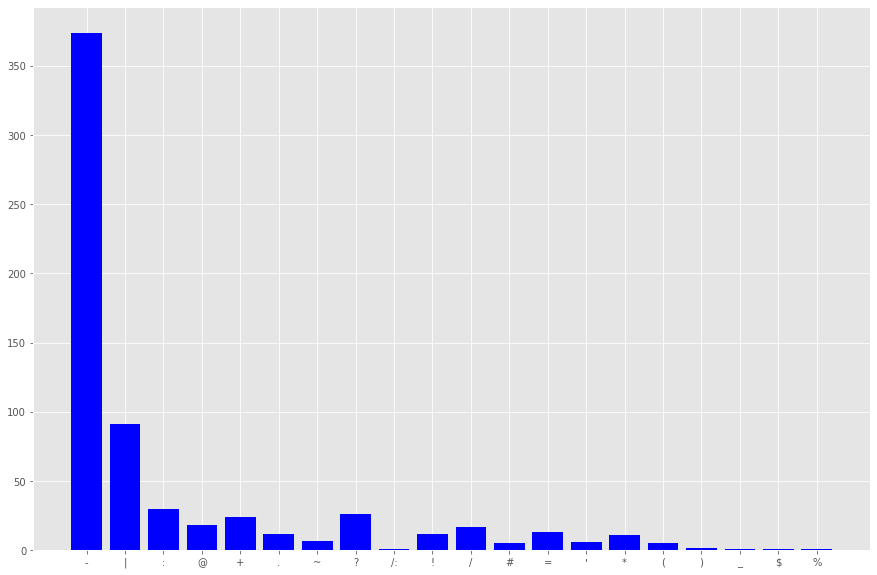

In [226]:
plt.figure(figsize=(15 , 10))
corpus = create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x , y , color = 'blue');

#### Common Words

In [0]:
counter=Counter(corpus)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

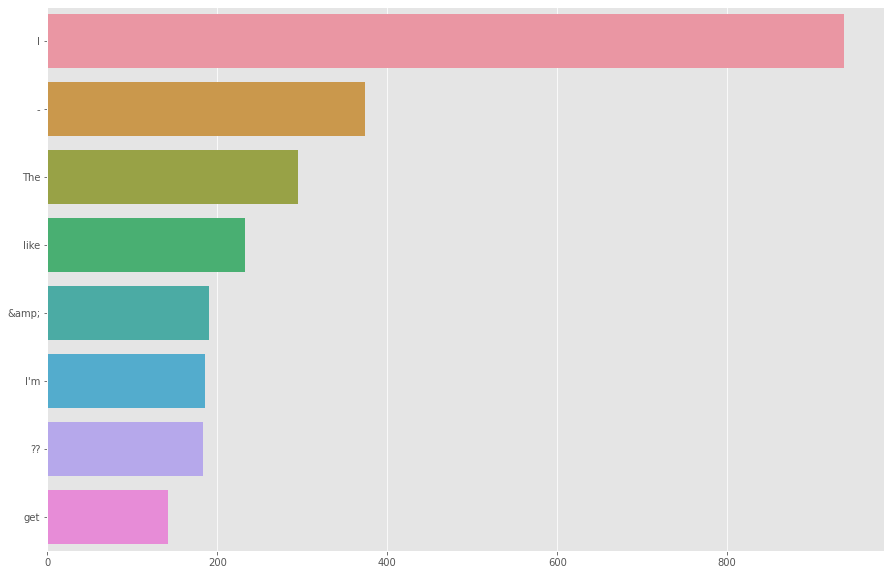

In [228]:
plt.figure(figsize=(15 , 10))
sns.barplot(x = y , y = x);

In [0]:
df = pd.concat([train , test])

## Data Preprocessing

1 . Removing stop words

2 . Remove Punctuations

3 . Remove Html

4 . Remove Emojis

5 . Spelling Corrections

6 . Removing Urls

In [0]:
## Concate both train and test part
df_new = pd.concat([train , test])

In [231]:
df_new.shape

(15226, 5)

In [232]:
df_new.isnull().sum()

id             0
keyword       61
location    5066
text           0
target         0
dtype: int64

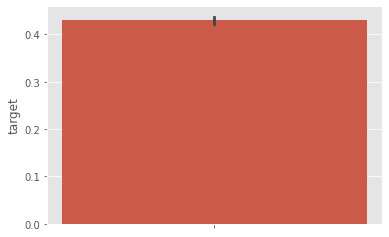

In [233]:
sns.barplot(y = 'target' , data = df_new)

In [234]:
df_new.head(20)

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,No keyword,NaN,All residents asked to 'shelter in place' are ...,1
3,6,No keyword,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,No keyword,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,No keyword,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,No keyword,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,No keyword,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,No keyword,NaN,There's an emergency evacuation happening now ...,1
9,15,No keyword,NaN,I'm afraid that the tornado is coming to our a...,1


In [235]:
df_new.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [236]:
df_new['text'][0]

0    Our Deeds are the Reason of this #earthquake M...
0    Our Deeds are the Reason of this #earthquake M...
Name: text, dtype: object

In [237]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
Name: text, dtype: object

In [238]:
train['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

### Removing Stopwords

In [0]:
stop_words = set(stopwords.words('english'))

In [0]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        
        string = ""
    
        all_text = all_text.lower()
        
        all_text = ''.join([i for i in all_text if not i.isdigit()]) 

        for word in all_text.split():
            if not word in stop_words:
                string +=word + " "

        train[col][ind] = string

In [0]:
for index , row in train.iterrows():
    if type(row['text']) is str:
        data_text_preprocessing(row['text'] , index , 'text')

In [242]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason #earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask. canada,1
2,5,No keyword,NaN,residents asked 'shelter place' notified offic...,1
3,6,No keyword,NaN,", people receive #wildfires evacuation orders ...",1
4,7,No keyword,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


In [0]:
def data_text_preprocessing(all_text , ind , col):
    if type(all_text) is not int:
        
        string = ""
             
        all_text = all_text.lower()
        
        all_text = ''.join([i for i in all_text if not i.isdigit()])

        for word in all_text.split():
            if not word in stop_words:
                string +=word + " "

        test[col][ind] = string

In [0]:
for index , row in test.iterrows():
    if type(row['text']) is str:
        data_text_preprocessing(row['text'] , index , 'text')

In [245]:
test.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason #earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1
3,6,NaN,NaN,", people receive #wildfires evacuation orders ...",1
4,7,NaN,NaN,got sent photo ruby #alaska smoke #wildfires p...,1


### Removing URLS

In [0]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [0]:
train['text'] = train['text'].apply(lambda x : remove_URL(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_URL(x))

### Remove HTML tags

In [0]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [0]:
train['text'] = train['text'].apply(lambda x : remove_html(x))
df_new['text'] = df_new['text'].apply(lambda x : remove_URL(x))
test['text'] = test['text'].apply(lambda x : remove_html(x))

### Remove Emoji's

In [0]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
df_new['text']=df_new['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))

In [252]:
df_new['text'][12]

12    #raining #flooding #Florida #TampaBay #Tampa 1...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
Name: text, dtype: object

### Remove Punctuations

In [0]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [0]:
df_new['text'] = df_new['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))

In [255]:
df_new['text'][12]

12    raining flooding Florida TampaBay Tampa 18 or ...
12    raining flooding Florida TampaBay Tampa 18 or ...
Name: text, dtype: object

In [256]:
train['text'][12]

'raining flooding florida tampabay tampa days ive lost count '

In [257]:
train.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,deeds reason earthquake may allah forgive us,1
1,4,No keyword,NaN,forest fire near la ronge sask canada,1
2,5,No keyword,NaN,residents asked shelter place notified officer...,1
3,6,No keyword,NaN,people receive wildfires evacuation orders ca...,1
4,7,No keyword,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [258]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,No keyword,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,No keyword,NaN,m utckm volcano hawaii,1
7611,10872,No keyword,NaN,police investigating ebike collided car little...,1
7612,10873,No keyword,NaN,latest homes razed northern california wildfir...,1


### Spelling corrections

In [0]:
# spell = SpellChecker()
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

In [0]:
# df_new['text'] = df_new['text'].apply(lambda x : correct_spellings(x))
# train['text'] = train['text'].apply(lambda x : correct_spellings(x))

In [261]:
train.tail()

,id,keyword,location,text,target
7608,10869,No keyword,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,No keyword,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,No keyword,NaN,m utckm volcano hawaii,1
7611,10872,No keyword,NaN,police investigating ebike collided car little...,1
7612,10873,No keyword,NaN,latest homes razed northern california wildfir...,1


In [262]:
df_new.head()

,id,keyword,location,text,target
0,1,No keyword,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,No keyword,NaN,Forest fire near La Ronge Sask Canada,1
2,5,No keyword,NaN,All residents asked to shelter in place are be...,1
3,6,No keyword,NaN,13000 people receive wildfires evacuation orde...,1
4,7,No keyword,NaN,Just got sent this photo from Ruby Alaska as s...,1


## Convert Text to TFIDF

In [0]:
x = train.drop(['keyword' , 'location' , 'target'] , axis = 1)
y = train['target']

In [264]:
x

,id,text
0,1,deeds reason earthquake may allah forgive us
1,4,forest fire near la ronge sask canada
2,5,residents asked shelter place notified officer...
3,6,people receive wildfires evacuation orders ca...
4,7,got sent photo ruby alaska smoke wildfires pou...
...,...,...
7608,10869,two giant cranes holding bridge collapse nearb...
7609,10870,ariaahrary thetawniest control wild fires cali...
7610,10871,m utckm volcano hawaii
7611,10872,police investigating ebike collided car little...


In [265]:
test

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearb...,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,NaN,NaN,m utckm volcano hawaii,1
7611,10872,NaN,NaN,police investigating ebike collided car little...,1


In [266]:
final_test = test.drop(['keyword' , 'location'] , axis = 1)
final_test

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders ca...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...
7608,10869,two giant cranes holding bridge collapse nearb...,1
7609,10870,ariaahrary thetawniest control wild fires cali...,1
7610,10871,m utckm volcano hawaii,1
7611,10872,police investigating ebike collided car little...,1


In [267]:
final_test.shape

(7613, 3)

In [0]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.20 , random_state = 78)

In [269]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(6090, 2)
(1523, 2)
(6090,)


### TFIDF on Text


In [0]:
count_vect = TfidfVectorizer()
X_train_BOW = count_vect.fit_transform(x_train['text'])
X_test_BOW = count_vect.transform(x_test['text'])
test_BOW = count_vect.transform(test['text'])

In [271]:
print("**Bow Vectorizer**")
print("="*50)


print(X_train_BOW.shape)
print(X_test_BOW.shape)
print(test_BOW.shape)

**Bow Vectorizer**
(6090, 14754)
(1523, 14754)
(7613, 14754)


In [272]:
X_train_BOW

<6090x14754 sparse matrix of type '<class 'numpy.float64'>'
	with 54638 stored elements in Compressed Sparse Row format>

In [273]:
test_BOW

<7613x14754 sparse matrix of type '<class 'numpy.float64'>'
	with 65932 stored elements in Compressed Sparse Row format>

## Apply DIfferent ML model on TFIDF

## Logistic Regression on TFIDF

In [0]:
#Standardising the train and test data

sc = StandardScaler(copy = True , with_mean = False , with_std = True)
X_train = sc.fit_transform(X_train_BOW)
X_test = sc.transform(X_test_BOW)
Test = sc.transform(test_BOW)

In [275]:
tuned_parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4]

cv_scores = []

for i in tqdm(tuned_parameters):
    model = LogisticRegression(penalty = 'l1' , C = i , n_jobs = -1)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'accuracy' , n_jobs = -1)
    cv_scores.append(scores.mean())

100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


In [276]:
optimal_C = tuned_parameters[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of C is %.3f.' % optimal_C)


The optimal value of C is 0.000.


In [277]:
lr = LogisticRegression(penalty = 'l2' , C = 0.0001 , n_jobs = -1)
lr.fit(X_train , y_train)
pred = lr.predict(X_test)

ac = accuracy_score(y_test , pred)
print(ac*100)

78.72619829284308


***Test Data Report***
Best C =  0.0001
AUC =  75.8032429194832


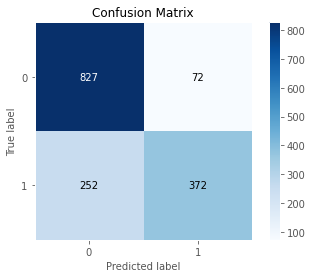

In [278]:
from sklearn import metrics
import scikitplot as skplt

print("***Test Data Report***")
print("Best C = ",optimal_C)
fpr, tpr, threshold = roc_curve(y_test , lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_test , lr.predict(X_test))
fpr2, tpr2, threshold2 = metrics.roc_curve(y_test , lr.predict(X_test))

roc_auc = metrics.auc(fpr, tpr)
roc_auc2 = metrics.auc(fpr2, tpr2)

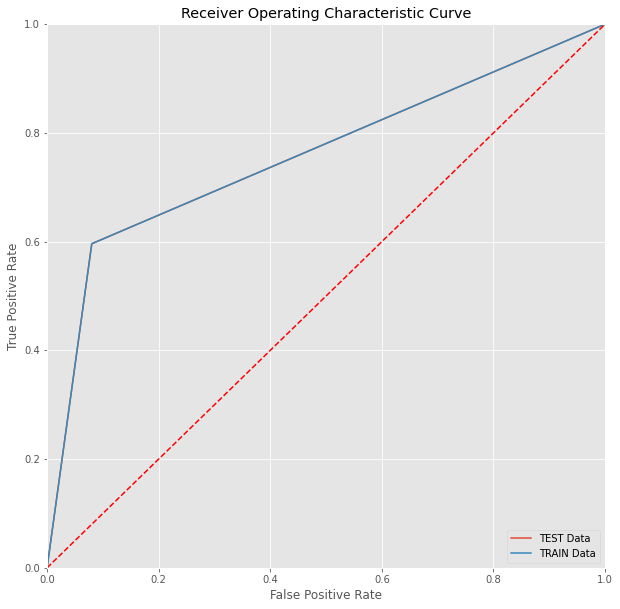

In [280]:
# plot ROC-curve
plt.figure(figsize = (10 , 10))
plt.title('Receiver Operating Characteristic Curve')
plt.gca()
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'AUC = %0.2f' % roc_auc2)
plt.legend(['TEST Data', 'TRAIN Data'],loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
feature_name = count_vect.get_feature_names()
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
top_20_positive_feature=sorted_feature[:-20:-1]

In [282]:
print("Positive feature top 20 :")
print("-------")
for i in top_20_positive_feature:
    print("%s\t-->\t%f"%(feature_name[i],weight[i]))

Positive feature top 20 :
-------
hiroshima	-->	0.022301
california	-->	0.021754
killed	-->	0.018857
fires	-->	0.018718
wildfire	-->	0.018249
suicide	-->	0.017620
fire	-->	0.017604
bombing	-->	0.017232
mh	-->	0.016968
pm	-->	0.015501
atomic	-->	0.015393
northern	-->	0.015247
news	-->	0.015001
homes	-->	0.014814
train	-->	0.014729
bomber	-->	0.014663
debris	-->	0.014351
outbreak	-->	0.014339
earthquake	-->	0.014233


In [0]:
w = lr.coef_
weight=w.reshape(-1)
sorted_feature = np.argsort(weight)
feature_name = count_vect.get_feature_names()
top_20_negative_feature = sorted_feature[:20]

In [284]:
print("Negative feature top 20 :")
print("-------")
for i in top_20_negative_feature:
    print("%s\t -->\t%f  "%(feature_name[i],weight[i]))

Negative feature top 20 :
-------
im	 -->	-0.016835  
body	 -->	-0.012627  
love	 -->	-0.012444  
like	 -->	-0.010420  
full	 -->	-0.010403  
harm	 -->	-0.009998  
bags	 -->	-0.009966  
panic	 -->	-0.009891  
ruin	 -->	-0.009711  
cant	 -->	-0.009481  
nowplaying	 -->	-0.009476  
lol	 -->	-0.009407  
blazing	 -->	-0.009364  
feel	 -->	-0.009284  
youtube	 -->	-0.009245  
curfew	 -->	-0.009091  
hes	 -->	-0.009090  
screamed	 -->	-0.009041  
know	 -->	-0.009033  
new	 -->	-0.008786  


In the above list it is clear that there are so many stop words that affects our model.we have to remove the stopwords.

## Apply KNN on TFIDF

In [285]:
knn = KNeighborsClassifier()
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac = accuracy_score(y_test , y_pred_knn)
print(ac*100)

67.82665791201575


In [0]:
n_folds = 5
parameters = {
        'n_neighbors': range (2 , 50 , 2)
        }


In [287]:
knn = KNeighborsClassifier()

tree = GridSearchCV(estimator = knn , param_grid = parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)
tree.fit(X_train , y_train)

score1 = tree.cv_results_

print(pd.DataFrame(score1).head())
print(tree.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



   mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0       0.003462      0.000294  ...          0.729187         0.003234
1       0.002856      0.000099  ...          0.676478         0.009514
2       0.002878      0.000213  ...          0.657348         0.007460
3       0.003066      0.000226  ...          0.645156         0.005755
4       0.002770      0.000081  ...          0.636617         0.004900

[5 rows x 21 columns]
{'n_neighbors': 2}


In [288]:
score1 = pd.DataFrame(score1)
score1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003462,0.000294,0.165310,0.023703,2,{'n_neighbors': 2},0.672414,0.669130,0.645320,0.672414,0.655993,0.663054,0.010737,1,0.724548,0.727627,0.728654,0.734195,0.730911,0.729187,0.003234
1,0.002856,0.000099,0.200750,0.011047,4,{'n_neighbors': 4},0.653530,0.659278,0.628900,0.652709,0.640394,0.646962,0.010929,2,0.668514,0.693555,0.670772,0.669335,0.680213,0.676478,0.009514
2,0.002878,0.000213,0.198739,0.009625,6,{'n_neighbors': 6},0.654351,0.645320,0.624795,0.646141,0.636289,0.641379,0.010074,3,0.650657,0.668103,0.658456,0.647578,0.661946,0.657348,0.007460
3,0.003066,0.000226,0.203913,0.003540,8,{'n_neighbors': 8},0.637110,0.637110,0.623153,0.638752,0.634647,0.634154,0.005655,4,0.635878,0.650862,0.649015,0.641010,0.649015,0.645156,0.005755
4,0.002770,0.000081,0.201700,0.005057,10,{'n_neighbors': 10},0.628900,0.633826,0.618227,0.628079,0.629721,0.627750,0.005156,5,0.629721,0.643062,0.637931,0.632389,0.639984,0.636617,0.004900


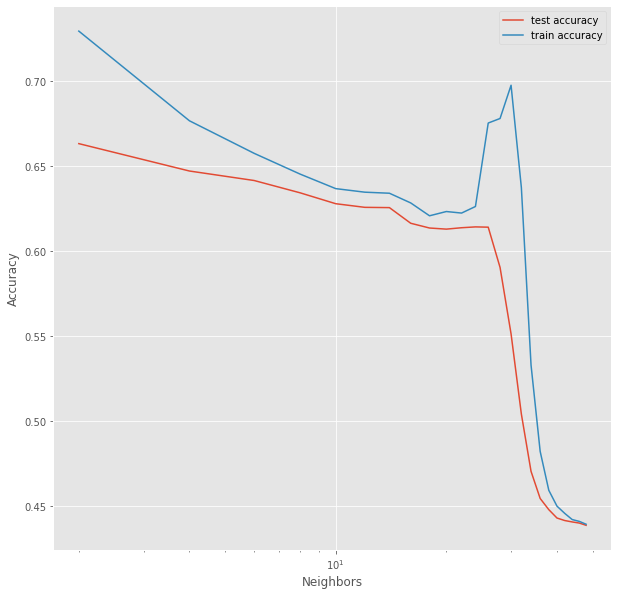

In [289]:
plt.figure(figsize=(10 , 10))
plt.plot(score1['param_n_neighbors'], score1['mean_test_score'])
plt.plot(score1['param_n_neighbors'], score1['mean_train_score'])
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'] , loc='upper right')
plt.xscale('log')

In [290]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train , y_train)

y_pred_knn = knn.predict(X_test)

ac_knn = accuracy_score(y_test , y_pred_knn)
print('After Cross-validation: ',ac*100)

After Cross-validation:  67.82665791201575


## Naive-Bayes on TFIDF

In [291]:
alpha = [] 
i = 0.001

while(i <= 1000):
    alpha.append(np.round(i,3))
    i *= 3

cv_scores = []

for k in tqdm(alpha):
    model = MultinomialNB(alpha = k)
    scores = cross_val_score(model , X_train , y_train , cv = 10 , scoring = 'f1_macro' , n_jobs = -1)
    cv_scores.append(scores.mean()) 

100%|██████████| 13/13 [00:01<00:00,  6.92it/s]


In [292]:
optimal_alpha = alpha[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 531.441.


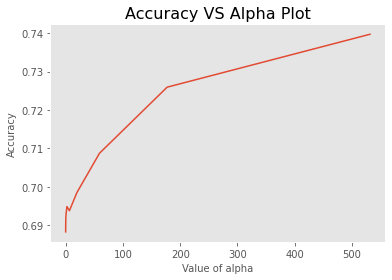


*******Train Data Report******

Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

F1 Score for each value of alpha :
  [68.831 68.867 68.875 68.964 69.006 69.184 69.3   69.49  69.383 69.855
 70.876 72.594 73.97 ]


In [293]:
# plot accuracy vs alpha 
plt.plot(alpha, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha Plot',size=16)
plt.grid()
plt.show()
print("\n*******Train Data Report******");
print("\nAlpha values :\n",alpha)
print("\nF1 Score for each value of alpha :\n ", np.round(cv_scores,5)*100)

In [0]:
model_bow_multinomial = MultinomialNB(alpha = optimal_alpha)

model_bow_multinomial.fit(X_train , y_train)

pred = model_bow_multinomial.predict(X_test)

***Test Data Report***
Accuracy =  76.16546290216678
f1_score =  75.42710947879243
precision_score =  75.3656806412712
recall_score =  75.49699095861499


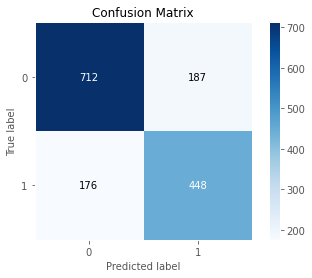

In [295]:
print("***Test Data Report***")
print('Accuracy = ', accuracy_score(y_test, pred)*100)
print("f1_score = ",f1_score(y_test, pred, average='macro')*100)

print("precision_score = " , precision_score(y_test , pred, average='macro')*100)
print("recall_score = " , recall_score(y_test, pred, average='macro')*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)

plt.show()

In [296]:
print(classification_report(y_test , pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       899
           1       0.71      0.72      0.71       624

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



## SVM on TFIDF

In [297]:
sv = SVC()
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

77.01904136572554


In [298]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
params = {"C": [0.01 , 0.1, 1, 10, 100, 1000]}

model = SVC()

model_cv_C = GridSearchCV(estimator = model, param_grid = params, cv = folds , verbose = 1 , return_train_score=True , n_jobs = -1)
model_cv_C.fit(X_train, y_train) 


cv_results = pd.DataFrame(model_cv_C.cv_results_)
cv_results

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.412876,0.236254,0.898503,0.005176,0.01,{'C': 0.01},0.581281,0.536946,0.574713,0.591133,0.542693,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
1,4.122527,0.056763,0.897806,0.010683,0.1,{'C': 0.1},0.581281,0.536946,0.574713,0.591133,0.542693,0.565353,0.021570,5,0.561371,0.572455,0.563013,0.558908,0.571018,0.565353,0.005393
2,4.073056,0.023754,0.854537,0.009098,1,{'C': 1},0.728243,0.687192,0.735632,0.733169,0.704433,0.717734,0.018861,4,0.978243,0.977422,0.977422,0.975164,0.976601,0.976970,0.001042
3,4.145533,0.049054,0.823164,0.012624,10,{'C': 10},0.738095,0.727422,0.770115,0.757800,0.731527,0.744992,0.016326,1,0.989943,0.990148,0.989943,0.988095,0.989122,0.989450,0.000764
4,4.215967,0.067475,0.829287,0.018834,100,{'C': 100},0.736453,0.724138,0.763547,0.753695,0.731527,0.741872,0.014563,2,0.990353,0.990558,0.990353,0.988506,0.989737,0.989901,0.000750
5,4.210133,0.010027,0.832257,0.020676,1000,{'C': 1000},0.736453,0.724138,0.763547,0.753695,0.731527,0.741872,0.014563,2,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.000790


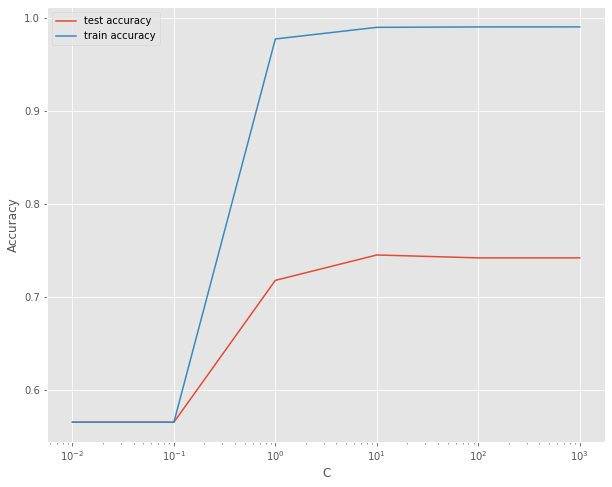

In [299]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [300]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)
gamma = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

model = SVC()

model_cv_g = GridSearchCV(estimator = model, param_grid = gamma, cv = folds , verbose = 1 , return_train_score=True ,  n_jobs = -1)
model_cv_g.fit(X_train, y_train) 

cv_results_g = pd.DataFrame(model_cv_g.cv_results_)
cv_results_g

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.147772,0.006266,0.903497,0.008049,1,{'gamma': 1},0.628079,0.606732,0.630542,0.642857,0.605090,0.622660,0.014573,4,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.00079
1,4.199480,0.007941,0.905580,0.016064,0.1,{'gamma': 0.1},0.628079,0.606732,0.630542,0.642857,0.605090,0.622660,0.014573,4,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.00079
2,4.228926,0.062616,0.888133,0.007298,0.01,{'gamma': 0.01},0.628079,0.608374,0.632184,0.643678,0.605090,0.623481,0.014637,3,0.990353,0.990764,0.990353,0.988506,0.989737,0.989943,0.00079
3,4.278496,0.040262,0.890204,0.031082,0.001,{'gamma': 0.001},0.637931,0.617406,0.652709,0.657635,0.616585,0.636453,0.017162,2,0.990148,0.990558,0.990148,0.988300,0.989532,0.989737,0.00079
4,3.984063,0.509287,0.833058,0.102760,0.0001,{'gamma': 0.0001},0.711002,0.676519,0.726601,0.720854,0.689655,0.704926,0.018977,1,0.983785,0.983990,0.984195,0.980911,0.983169,0.983210,0.00120


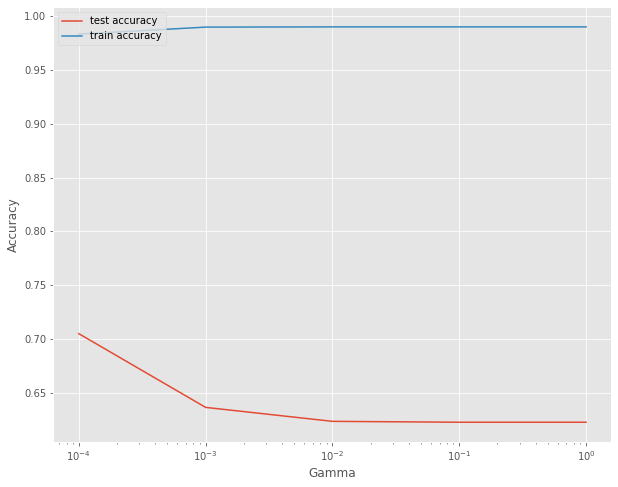

In [301]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_test_score'])
plt.plot(cv_results_g['param_gamma'], cv_results_g['mean_train_score'])
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [302]:
print(model_cv_C.best_params_)
print(model_cv_g.best_params_)

{'C': 10}
{'gamma': 0.0001}


In [303]:
sv = SVC(C = 10 , gamma = 0.0001)
sv.fit(X_train , y_train)

y_pred_svm = sv.predict(X_test)

ac_svr = accuracy_score(y_test , y_pred_svm)
print(ac_svr*100)

75.57452396585687


In [304]:
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score

alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
auc_score=[]


for i in tqdm(alpha):
    model = linear_model.SGDClassifier(alpha=i, loss='hinge', class_weight='balanced')
    model.fit(X_train, y_train)
    
    Cal_CV_model = CalibratedClassifierCV(model, method="sigmoid",cv=10)
    Cal_CV_model.fit(X_train, y_train)
    predict_y = Cal_CV_model.predict_proba(X_train)
    preds = predict_y[:,1]
    roc_auc = roc_auc_score(y_train, preds)
    auc_score.append(roc_auc)

100%|██████████| 9/9 [00:02<00:00,  3.40it/s]


In [305]:
# determining best value of alpha
optimal_alpha = alpha[auc_score.index(max(auc_score))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.010.


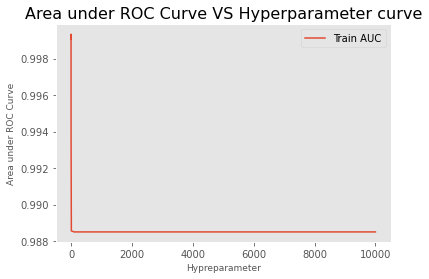

In [306]:
# plot accuracy vs alpha 
plt.plot(alpha, auc_score,label="Train AUC")
plt.xlabel('Hypreparameter',size=9)
plt.ylabel('Area under ROC Curve',size=9)
plt.title('Area under ROC Curve VS Hyperparameter curve',size=16)
plt.legend(loc='best')
plt.grid()
plt.show()

***Test Data Report***
Best alpha =  0.01
AUC =  73.55599883060951


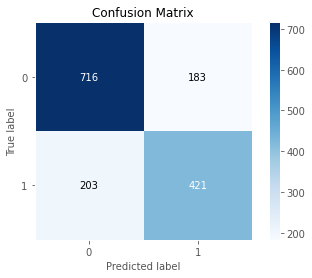

In [307]:
model = linear_model.SGDClassifier(alpha=optimal_alpha, loss='hinge', class_weight='balanced')
model.fit(X_train, y_train)

lr = CalibratedClassifierCV(model, method="sigmoid",cv=10)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)


print("***Test Data Report***")
print("Best alpha = ",optimal_alpha)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Decision Tree on TFIDF

In [308]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

73.21076822061721


In [309]:
n_folds = 5
parameters = {'min_samples_split': range(20 , 200 , 20)}

dtree = DecisionTreeClassifier(random_state = 100)

tree_split = GridSearchCV(dtree, parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_split.fit(X_train, y_train)


cv_results_ms = pd.DataFrame(tree_split.cv_results_)
cv_results_ms

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.202332,0.050391,0.002766,0.000180,20,{'min_samples_split': 20},0.748768,0.750411,0.733169,0.737274,0.742200,0.742365,0.006576,1,0.938013,0.943144,0.939039,0.933908,0.936576,0.938136,0.003041
1,2.143358,0.057372,0.002518,0.000194,40,{'min_samples_split': 40},0.747126,0.750411,0.721675,0.742200,0.737274,0.739737,0.010069,9,0.923440,0.929598,0.925493,0.913998,0.918514,0.922209,0.005440
2,2.155398,0.057897,0.002653,0.000114,60,{'min_samples_split': 60},0.747947,0.749589,0.722496,0.739737,0.739737,0.739901,0.009608,7,0.914819,0.921388,0.916667,0.903736,0.912562,0.913834,0.005825
3,2.145851,0.062606,0.002773,0.000147,80,{'min_samples_split': 80},0.746305,0.749589,0.724959,0.740558,0.738095,0.739901,0.008507,6,0.907635,0.915640,0.906404,0.899425,0.905788,0.906979,0.005182
4,2.145532,0.068807,0.002687,0.000085,100,{'min_samples_split': 100},0.747126,0.749589,0.724959,0.740558,0.737274,0.739901,0.008680,7,0.906199,0.914819,0.906404,0.899425,0.901888,0.905747,0.005250
5,2.119627,0.073460,0.002648,0.000186,120,{'min_samples_split': 120},0.748768,0.748768,0.724138,0.739737,0.739737,0.740230,0.009003,5,0.905583,0.910714,0.904967,0.896552,0.900246,0.903612,0.004844
6,2.111212,0.067961,0.002632,0.000075,140,{'min_samples_split': 140},0.748768,0.749589,0.723317,0.739737,0.739737,0.740230,0.009456,4,0.905583,0.908662,0.903325,0.895936,0.900246,0.902750,0.004382
7,2.101906,0.067467,0.002914,0.000632,160,{'min_samples_split': 160},0.748768,0.752053,0.723317,0.739737,0.739737,0.740722,0.009980,2,0.905583,0.908046,0.902709,0.895936,0.900246,0.902504,0.004206
8,1.940720,0.316685,0.002438,0.000159,180,{'min_samples_split': 180},0.748768,0.752053,0.723317,0.739737,0.739737,0.740722,0.009980,2,0.905583,0.908046,0.902709,0.895936,0.900246,0.902504,0.004206


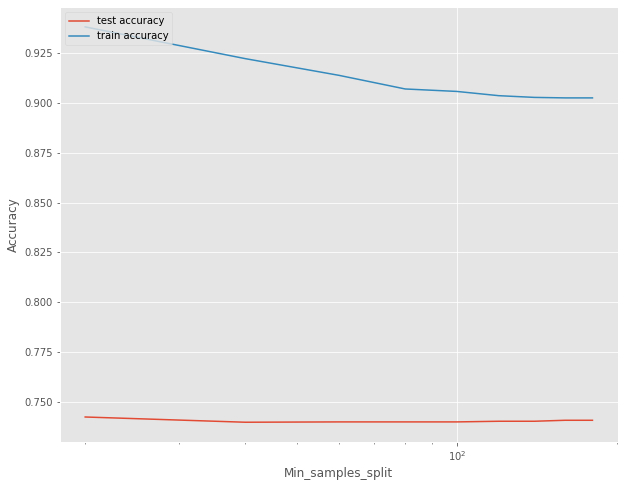

In [310]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_test_score'])
plt.plot(cv_results_ms['param_min_samples_split'] , cv_results_ms['mean_train_score'])
plt.xlabel('Min_samples_split')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [311]:
n_folds = 5
parameters = {'min_samples_leaf': range (1 , 20)}

dtree = DecisionTreeClassifier()

tree_ml = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_ml.fit(X_train, y_train)


cv_results_ml = pd.DataFrame(tree_ml.cv_results_)
cv_results_ml

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.410263,0.087832,0.002974,0.000953,1,{'min_samples_leaf': 1},0.748768,0.749589,0.733169,0.738916,0.724959,0.739080,0.009367,11,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845
1,2.104916,0.039767,0.002465,0.000155,2,{'min_samples_leaf': 2},0.732348,0.729885,0.721675,0.736453,0.706076,0.725287,0.010750,19,0.918719,0.921182,0.917077,0.916461,0.918719,0.918432,0.001640
2,1.767502,0.019238,0.002487,0.000276,3,{'min_samples_leaf': 3},0.737274,0.742200,0.729064,0.735632,0.710181,0.730870,0.011166,16,0.892241,0.892447,0.891831,0.890394,0.892241,0.891831,0.000746
3,1.544306,0.014910,0.002374,0.000121,4,{'min_samples_leaf': 4},0.738095,0.735632,0.731527,0.750411,0.724959,0.736125,0.008415,15,0.865969,0.863300,0.865969,0.863711,0.865148,0.864819,0.001121
4,1.350705,0.014619,0.002131,0.000152,5,{'min_samples_leaf': 5},0.737274,0.741379,0.742200,0.736453,0.729885,0.737438,0.004388,14,0.851806,0.852422,0.848112,0.848933,0.853448,0.850944,0.002062
5,1.194831,0.036412,0.002169,0.000151,6,{'min_samples_leaf': 6},0.753695,0.749589,0.729064,0.736453,0.733169,0.740394,0.009566,9,0.836617,0.838054,0.839080,0.834975,0.839080,0.837562,0.001577
6,1.064030,0.022705,0.002057,0.000159,7,{'min_samples_leaf': 7},0.747126,0.752874,0.738095,0.737274,0.733990,0.741872,0.007017,7,0.828407,0.829433,0.831486,0.824302,0.829639,0.828654,0.002392
7,0.978055,0.016486,0.002098,0.000116,8,{'min_samples_leaf': 8},0.761905,0.750411,0.733990,0.761084,0.734811,0.748440,0.012162,2,0.820608,0.818144,0.824507,0.816708,0.822660,0.820525,0.002852
8,0.926177,0.015175,0.001978,0.000252,9,{'min_samples_leaf': 9},0.755337,0.749589,0.738095,0.745484,0.736453,0.744992,0.007055,4,0.816092,0.815066,0.821634,0.810345,0.816708,0.815969,0.003608
9,0.844902,0.008766,0.001943,0.000100,10,{'min_samples_leaf': 10},0.756979,0.748768,0.747126,0.742200,0.747947,0.748604,0.004770,1,0.806240,0.806445,0.813834,0.804803,0.806650,0.807594,0.003187


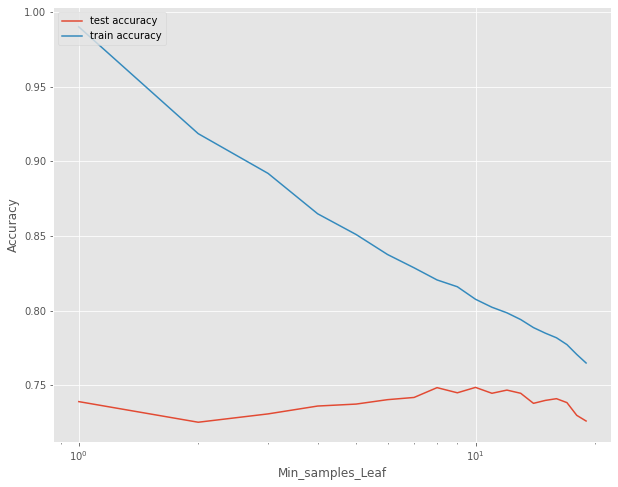

In [312]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_test_score'])
plt.plot(cv_results_ml['param_min_samples_leaf'] , cv_results_ml['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [313]:
n_folds = 5
parameters = {'max_depth':range (1,20)}

dtree = DecisionTreeClassifier()

tree_d = GridSearchCV(dtree , parameters , cv=n_folds , n_jobs = -1 , return_train_score = True)
tree_d.fit(X_train, y_train)


cv_results_d = pd.DataFrame(tree_d.cv_results_)
cv_results_d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.114902,0.009330,0.001270,0.000123,1,{'max_depth': 1},0.581281,0.581281,0.574713,0.579639,0.574713,0.578325,0.003010,19,0.578612,0.578612,0.579639,0.579023,0.580255,0.579228,0.000636
1,0.118852,0.005241,0.001033,0.000088,2,{'max_depth': 2},0.596880,0.591954,0.587849,0.594417,0.584565,0.591133,0.004437,18,0.591338,0.590928,0.594007,0.592159,0.594622,0.592611,0.001459
2,0.122941,0.003103,0.001091,0.000100,3,{'max_depth': 3},0.610837,0.607553,0.596059,0.612479,0.590312,0.603448,0.008720,17,0.603243,0.603859,0.606732,0.602627,0.608169,0.604926,0.002146
3,0.134072,0.004459,0.001438,0.000391,4,{'max_depth': 4},0.621511,0.615764,0.602627,0.617406,0.600164,0.611494,0.008491,16,0.613300,0.614532,0.617816,0.613300,0.618227,0.615435,0.002163
4,0.146531,0.006361,0.001239,0.000113,5,{'max_depth': 5},0.631363,0.624795,0.611658,0.631363,0.612479,0.622332,0.008720,15,0.622332,0.623974,0.631568,0.622126,0.626847,0.625369,0.003530
5,0.147994,0.003597,0.001272,0.000146,6,{'max_depth': 6},0.626437,0.635468,0.619869,0.638752,0.625616,0.629228,0.006900,14,0.630952,0.635878,0.639984,0.634647,0.637931,0.635878,0.003061
6,0.161446,0.003798,0.001444,0.000385,7,{'max_depth': 7},0.633005,0.637931,0.628079,0.636289,0.628900,0.632841,0.003900,13,0.638957,0.644499,0.647167,0.642652,0.644089,0.643473,0.002689
7,0.162668,0.001895,0.001132,0.000091,8,{'max_depth': 8},0.650246,0.639573,0.633005,0.639573,0.637931,0.640066,0.005631,12,0.649836,0.652094,0.655993,0.648810,0.650862,0.651519,0.002488
8,0.172311,0.003195,0.001278,0.000095,9,{'max_depth': 9},0.651888,0.644499,0.635468,0.646962,0.640394,0.643842,0.005602,11,0.656814,0.659072,0.662767,0.656404,0.657430,0.658498,0.002320
9,0.189219,0.005359,0.001323,0.000108,10,{'max_depth': 10},0.655172,0.647783,0.642857,0.649425,0.649425,0.648933,0.003941,10,0.662151,0.665025,0.669335,0.663998,0.662767,0.664655,0.002542


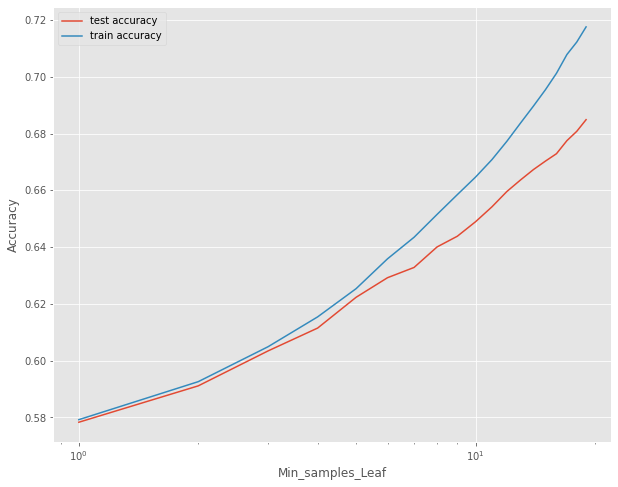

In [314]:
plt.figure(figsize=(10 , 8))
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_test_score'])
plt.plot(cv_results_d['param_max_depth'] , cv_results_d['mean_train_score'])
plt.xlabel('Min_samples_Leaf')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [315]:
print(tree_split.best_params_)
print(tree_ml.best_params_)
print(tree_d.best_params_)

{'min_samples_split': 20}
{'min_samples_leaf': 10}
{'max_depth': 19}


In [316]:
dt = DecisionTreeClassifier(max_depth = 19 , min_samples_leaf = 1 , min_samples_split = 180)
dt.fit(X_train , y_train)


y_pred_dt = dt.predict(X_test)

ac = accuracy_score(y_test , y_pred_dt)
print(ac*100)

69.86211424819435


***Test Data Report***
Best max_depth =  20
Best min_samples_split =  80
AUC =  73.55599883060951


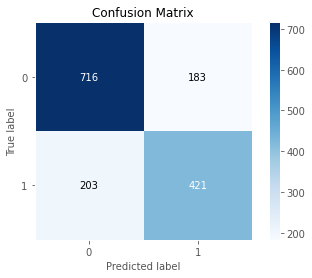

In [317]:
optimal_depth = 20
optimal_split = 80

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best min_samples_split = ",optimal_split)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

## Random Forest on TFIDF

In [318]:
max_depths = [2,4,6,9,11]
base_learners = [1, 5, 10, 50, 100]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}


model = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True)
model.fit(X_train, y_train)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

Model with best parameters :
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy of the model :  0.8750435748864256


In [319]:
y_pred_rf = model.predict(X_test)
ac = accuracy_score(y_test , y_pred_rf)
ac

0.7393302692055155

In [320]:
dataframe = pd.DataFrame(model.cv_results_)
dataframe.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.009906,0.000464,0.005111,0.002047,2,1,"{'max_depth': 2, 'n_estimators': 1}",0.505781,0.501134,0.507056,0.504657,0.002545,25,0.509180,0.505949,0.509986,0.508372,0.001744
1,0.024494,0.002275,0.004844,0.000059,2,5,"{'max_depth': 2, 'n_estimators': 5}",0.520951,0.546817,0.532578,0.533449,0.010578,21,0.528802,0.553734,0.542775,0.541770,0.010203
2,0.042011,0.002992,0.006432,0.000122,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.583057,0.570508,0.569660,0.574408,0.006125,18,0.588649,0.586478,0.576288,0.583805,0.005389
3,0.176777,0.004182,0.019900,0.000710,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.685964,0.674853,0.675155,0.678657,0.005168,12,0.740175,0.716145,0.736559,0.730960,0.010579
4,0.354378,0.002972,0.038445,0.003531,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.740984,0.732429,0.724555,0.732656,0.006709,9,0.787345,0.810839,0.789346,0.795843,0.010635


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



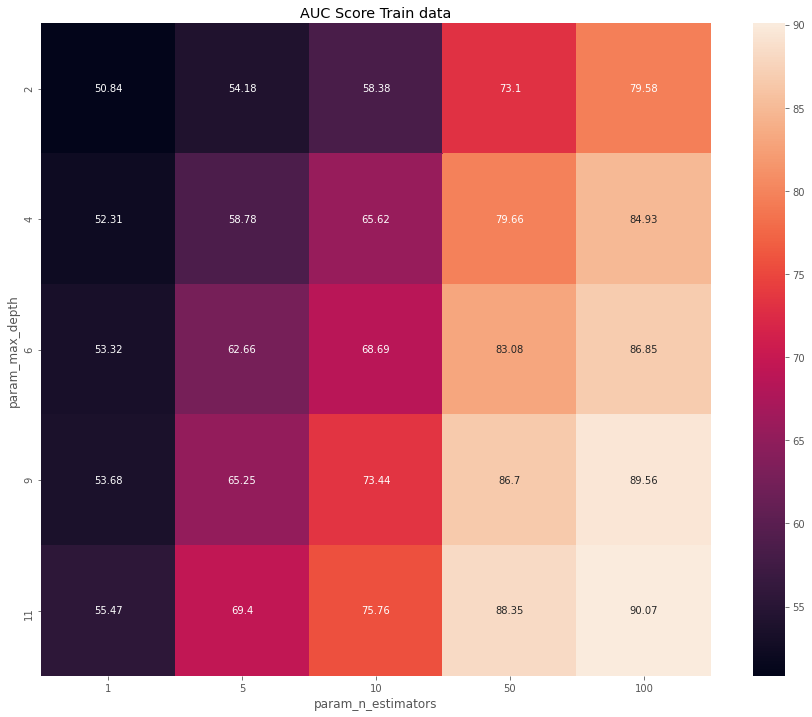

In [321]:
# Train Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_train_score*100, annot=True, fmt='.4g');
ax = plt.axes()
ax.set_title('AUC Score Train data')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



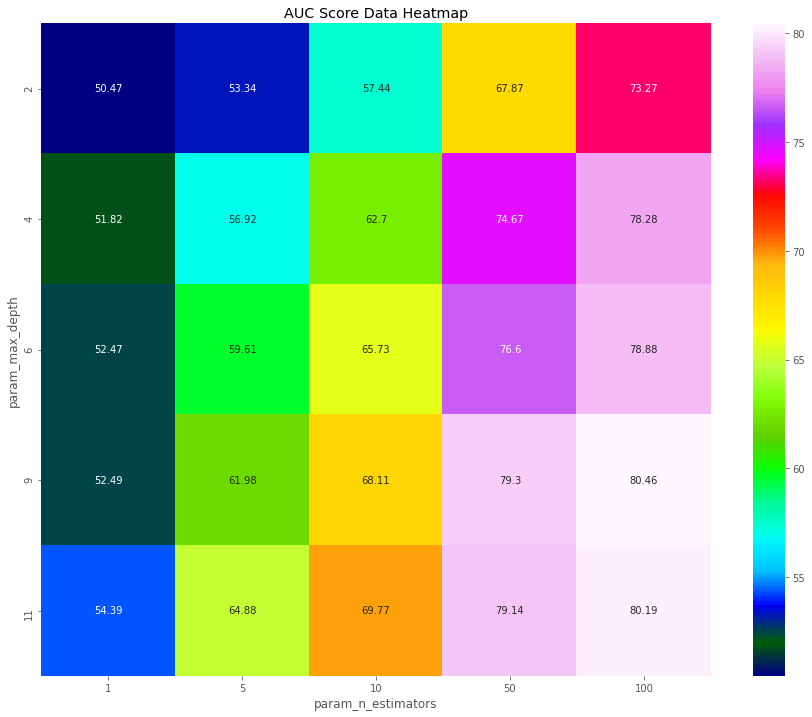

In [322]:
# CV Data Auc Score Vs hyperparameter Heatmap
max_scores = dataframe.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize = (15 , 12))
sns.heatmap(max_scores.mean_test_score*100, annot=True, fmt='.4g' , cmap = 'gist_ncar')
ax = plt.axes()
ax.set_title('AUC Score Data Heatmap')
plt.show()

***Test Data Report***
Best max_depth =  11
Best Base Learners =  100
AUC =  70.21218376543739


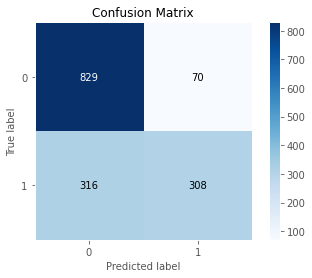

In [323]:
optimal_depth = 11
optimal_estimators = 100

lr = RandomForestClassifier(n_estimators=optimal_estimators, max_depth=optimal_depth, class_weight='balanced')
lr.fit(X_train_BOW,y_train)
pred = lr.predict(X_test_BOW)

print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [324]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

y_pred_rf = rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

79.25147734734077


In [0]:
test_pred = rf.predict(test_BOW)

In [0]:
# test_pred = rf.predict(test_BOW)
# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02.csv', index=False)

In [327]:
n_folds = 10
parameters = {'max_depth': range(2, 30, 2)}

rf = RandomForestClassifier(random_state = 100)
grd_search_max = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_max.fit(X_train , y_train)
print('Best parameter for max_depth: ',grd_search_max.best_params_)

scores = grd_search_max.cv_results_
pd.DataFrame(scores).head()

Best parameter for max_depth:  {'max_depth': 28}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.436565,0.009280,0.023716,0.004288,2,{'max_depth': 2},0.566502,0.566502,0.569787,0.566502,0.566502,0.564860,0.566502,0.564860,0.566502,0.566502,0.566502,0.001272,14,0.569422,0.565408,0.569604,0.566138,0.568874,0.569604,0.566867,0.565590,0.569787,0.568874,0.568017,0.001708
1,0.600239,0.010326,0.022164,0.002433,4,{'max_depth': 4},0.579639,0.594417,0.592775,0.589491,0.586207,0.577997,0.594417,0.581281,0.577997,0.579639,0.585386,0.006537,13,0.584565,0.591863,0.584747,0.587302,0.594417,0.587484,0.586937,0.589126,0.586024,0.587666,0.588013,0.002927
2,0.797302,0.019790,0.021946,0.003148,6,{'max_depth': 6},0.610837,0.604269,0.610837,0.607553,0.604269,0.600985,0.627258,0.600985,0.602627,0.597701,0.606732,0.007952,12,0.609378,0.610108,0.617223,0.606459,0.623244,0.617223,0.614851,0.616311,0.611567,0.609378,0.613574,0.004808
3,1.016557,0.014179,0.022012,0.002955,8,{'max_depth': 8},0.648604,0.628900,0.623974,0.638752,0.623974,0.620690,0.643678,0.625616,0.622332,0.620690,0.629721,0.009666,11,0.638570,0.630177,0.638752,0.634921,0.639117,0.643131,0.635650,0.640212,0.633461,0.634556,0.636855,0.003590
4,1.208393,0.033182,0.021181,0.001551,10,{'max_depth': 10},0.668309,0.633826,0.632184,0.653530,0.642036,0.628900,0.656814,0.637110,0.637110,0.637110,0.642693,0.012026,10,0.654443,0.642219,0.654443,0.651341,0.655902,0.654808,0.650064,0.653348,0.650064,0.651523,0.651815,0.003746


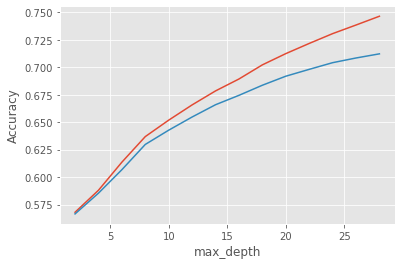

In [328]:
plt.figure()
plt.plot(scores["param_max_depth"],scores["mean_train_score"],label="Training accuracy")
plt.plot(scores["param_max_depth"],scores["mean_test_score"],label="Test accuracy")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()


In [329]:
n_folds = 5
parameters = {'n_estimators': range(50, 500, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_est = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1 , return_train_score = True)

grd_search_est.fit(X_train, y_train)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

scores_1 = grd_search_est.cv_results_
pd.DataFrame(scores_1).head()

Best parameter for n_estimators:  {'n_estimators': 200}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,10.707653,0.072289,0.090092,0.007220,50,{'n_estimators': 50},0.784893,0.777504,0.769294,0.766831,0.774220,0.774548,0.006372,7,0.987890,0.990558,0.987685,0.988506,0.988711,0.988670,0.001017
1,21.517868,0.394369,0.172744,0.008134,100,{'n_estimators': 100},0.782430,0.776683,0.771757,0.763547,0.777504,0.774384,0.006389,8,0.990148,0.991379,0.988711,0.989737,0.989327,0.989860,0.000896
2,32.414070,0.406163,0.257743,0.009179,150,{'n_estimators': 150},0.787356,0.778325,0.772578,0.770936,0.775862,0.777011,0.005773,2,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845
3,43.308105,0.389632,0.344510,0.007519,200,{'n_estimators': 200},0.788177,0.779967,0.770115,0.773399,0.778325,0.777997,0.006179,1,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845
4,54.078854,0.693934,0.420112,0.007588,250,{'n_estimators': 250},0.785714,0.775041,0.768473,0.775041,0.776683,0.776190,0.005534,4,0.990148,0.991379,0.988916,0.989737,0.989327,0.989901,0.000845


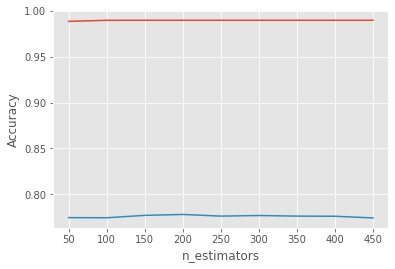

In [330]:
plt.figure()
plt.plot(scores_1["param_n_estimators"],scores_1["mean_train_score"],label="Training accuracy")
plt.plot(scores_1["param_n_estimators"],scores_1["mean_test_score"],label="Test accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [331]:
n_folds = 5
parameters = {'min_samples_leaf': range(30, 400, 50)}

rf = RandomForestClassifier(random_state = 100)
grd_search_lf = GridSearchCV(rf , parameters , cv = n_folds , return_train_score = True)

grd_search_lf.fit(X_train, y_train)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)

scores_2 = grd_search_lf.cv_results_
pd.DataFrame(scores_2).head()

Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.231972,0.010786,0.016614,0.002046,30,{'min_samples_leaf': 30},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
1,0.202654,0.004140,0.014862,0.000341,80,{'min_samples_leaf': 80},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
2,0.196320,0.007956,0.014791,0.000316,130,{'min_samples_leaf': 130},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
3,0.191263,0.002870,0.015488,0.000931,180,{'min_samples_leaf': 180},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101
4,0.195812,0.005608,0.014686,0.000230,230,{'min_samples_leaf': 230},0.565681,0.565681,0.565681,0.56486,0.56486,0.565353,0.000402,1,0.565271,0.565271,0.565271,0.565476,0.565476,0.565353,0.000101


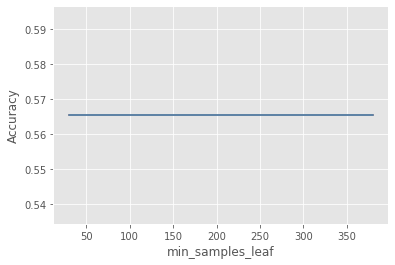

In [332]:
plt.figure()
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_train_score"],label="Training accuracy")
plt.plot(scores_2["param_min_samples_leaf"],scores_2["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [333]:
n_folds = 5
parameters = {'min_samples_split': range(10, 400, 50)}

rf = RandomForestClassifier()
grd_search_sp = GridSearchCV(rf , parameters , cv = n_folds , n_jobs = -1, return_train_score = True)

grd_search_sp.fit(X_train, y_train)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)

score_3 = grd_search_sp.cv_results_
pd.DataFrame(score_3).head()

Best parameter for min_samples_split:  {'min_samples_split': 210}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,15.995439,0.096620,0.170926,0.003617,10,{'min_samples_split': 10},0.789819,0.775041,0.769294,0.778325,0.773399,0.777176,0.006959,8,0.981732,0.979269,0.981322,0.980911,0.979885,0.980624,0.000914
1,15.056869,0.136285,0.165070,0.004027,60,{'min_samples_split': 60},0.783251,0.783251,0.777504,0.777504,0.777504,0.779803,0.002816,4,0.959360,0.965107,0.962438,0.961412,0.961823,0.962028,0.001854
2,15.025208,0.138993,0.163021,0.003932,110,{'min_samples_split': 110},0.782430,0.776683,0.770936,0.781609,0.775041,0.777340,0.004263,7,0.957718,0.960386,0.956281,0.957512,0.959154,0.958210,0.001420
3,15.057708,0.258258,0.162725,0.004323,160,{'min_samples_split': 160},0.782430,0.785714,0.780788,0.781609,0.776683,0.781445,0.002910,2,0.956691,0.962028,0.958744,0.956076,0.958744,0.958456,0.002084
4,14.886666,0.210588,0.163406,0.004282,210,{'min_samples_split': 210},0.784893,0.787356,0.775862,0.784893,0.775862,0.781773,0.004910,1,0.955049,0.957512,0.953407,0.956281,0.959565,0.956363,0.002100


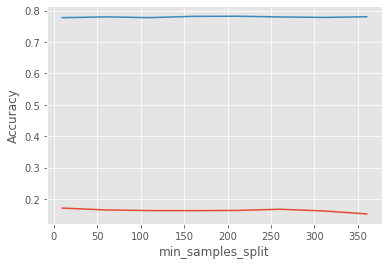

In [334]:
plt.figure()
plt.plot(score_3["param_min_samples_split"],score_3["mean_score_time"],label="Training accuracy")
plt.plot(score_3["param_min_samples_split"],score_3["mean_test_score"],label="Test accuracy")
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

In [335]:
print('Best parameter for max_depth: ',grd_search_max.best_params_)
print('Best parameter for min_samples_leaf: ',grd_search_lf.best_params_)
print('Best parameter for min_samples_split: ',grd_search_sp.best_params_)
print('Best parameter for n_estimators: ',grd_search_est.best_params_)

Best parameter for max_depth:  {'max_depth': 28}
Best parameter for min_samples_leaf:  {'min_samples_leaf': 30}
Best parameter for min_samples_split:  {'min_samples_split': 210}
Best parameter for n_estimators:  {'n_estimators': 200}


In [336]:
new_rf = RandomForestClassifier(n_estimators = 200 , max_depth = 28 , min_samples_leaf = 30 , min_samples_split = 110)
new_rf.fit(X_train , y_train)

y_pred_rf = new_rf.predict(X_test)

ac_rf = accuracy_score(y_test , y_pred_rf)
print(ac_rf*100)

59.02823374917925


## GBDT on TFIDF

In [0]:
learn_rate = {'learning_rate': [0.001 , 0.01 , 0.1 , 1.0 , 1.3]}
folds = 5

In [338]:
GBC = GradientBoostingClassifier()

grd_search_lr = GridSearchCV(GBC , cv = folds , param_grid = learn_rate , n_jobs = -1)
grd_search_lr.fit(X_train, y_train)
print('Best parameter for max_depth: ' , grd_search_lr.best_params_)

cv_results_gbdt = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_gbdt.head()

Best parameter for max_depth:  {'learning_rate': 1.0}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.315879,0.124648,0.004142,0.001096,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,12.319556,0.125332,0.003656,0.000141,0.01,{'learning_rate': 0.01},0.628900,0.633826,0.615764,0.633826,0.613300,0.625123,0.008867,4
2,12.367299,0.172413,0.003755,0.000144,0.1,{'learning_rate': 0.1},0.738095,0.723317,0.738095,0.720033,0.738095,0.731527,0.008111,3
3,12.232751,0.124108,0.004126,0.000231,1,{'learning_rate': 1.0},0.752053,0.728243,0.740558,0.740558,0.747947,0.741872,0.008121,1
4,11.132523,2.416639,0.003548,0.000439,1.3,{'learning_rate': 1.3},0.756158,0.740558,0.729885,0.747947,0.732348,0.741379,0.009756,2


In [0]:
sub_sample = {"subsample": [0.3, 0.6, 0.9]}
folds = 5

In [340]:
GBC = GradientBoostingClassifier()

grd_search_ss = GridSearchCV(GBC , cv = folds , param_grid = sub_sample)
grd_search_ss.fit(X_train, y_train)
print('Best parameter for subsample: ',grd_search_ss.best_params_)

cv_results_sub = pd.DataFrame(grd_search_lr.cv_results_)
cv_results_sub.head()

Best parameter for subsample:  {'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.315879,0.124648,0.004142,0.001096,0.001,{'learning_rate': 0.001},0.565681,0.565681,0.565681,0.564860,0.564860,0.565353,0.000402,5
1,12.319556,0.125332,0.003656,0.000141,0.01,{'learning_rate': 0.01},0.628900,0.633826,0.615764,0.633826,0.613300,0.625123,0.008867,4
2,12.367299,0.172413,0.003755,0.000144,0.1,{'learning_rate': 0.1},0.738095,0.723317,0.738095,0.720033,0.738095,0.731527,0.008111,3
3,12.232751,0.124108,0.004126,0.000231,1,{'learning_rate': 1.0},0.752053,0.728243,0.740558,0.740558,0.747947,0.741872,0.008121,1
4,11.132523,2.416639,0.003548,0.000439,1.3,{'learning_rate': 1.3},0.756158,0.740558,0.729885,0.747947,0.732348,0.741379,0.009756,2


In [341]:
#GBC = GradientBoostingClassifier(subsample = 0.6 , learning_rate = 0.1 , n_estimators=50 , max_features = 8 , min_samples_leaf = 30 , min_samples_split = 10)

GBC = GradientBoostingClassifier(subsample = 0.3 , learning_rate = 1.0 )
GBC.fit(X_train , y_train)

y_gbr = GBC.predict(X_test)

ac_gbr = accuracy_score(y_test , y_gbr)
print(ac_gbr*100)

73.14510833880499


## XGB on TFIDF

In [342]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac_xg = accuracy_score(y_test , y_pred)
print(ac_xg*100)

72.48850952068287


In [0]:
max_depths = [2,4,6,9,11 ,15 , 20]
base_learners = [1, 5, 10, 50, 100 , 150 , 200]
param_grid = {'max_depth': max_depths,'n_estimators':base_learners}

model = GridSearchCV(xgb.XGBClassifier(scale_pos_weight=1), param_grid, scoring = 'roc_auc', cv=3 , n_jobs = -1 , return_train_score = True) 
model.fit(X_train, y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_train, y_train))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [0]:
optimal_depth = 15
optimal_estimators = 200


xg_model = xgb.XGBClassifier(max_depth=optimal_depth, n_estimators=optimal_estimators)
xg_model.fit(X_train,y_train)

pred = xg_model.predict(X_test)



print("***Test Data Report***")
print("Best max_depth = ",optimal_depth)
print("Best Base Learners = ",optimal_estimators)
fpr, tpr, threshold = metrics.roc_curve(y_test, lr.predict(X_test))
auc = metrics.auc(fpr, tpr)
print("AUC = ",auc*100)
skplt.metrics.plot_confusion_matrix(y_test, pred)
plt.show()

In [0]:
# test_pred = xg_model.predict(test_BOW)

# submission['target'] = test_pred.astype(int)
# submission.to_csv('submission02xgb.csv', index=False)

In [0]:
## Using ANN

In [0]:
X_train.shape

In [0]:
y_train.shape

In [0]:
test_BOW

In [0]:
import tensorflow as tf
from sklearn.metrics import accuracy_score , confusion_matrix

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [0]:
classifier = Sequential()

In [0]:
classifier.add(Dense(output_dim = 7318 , init = 'uniform' , activation = 'relu' , input_dim = 14754))
#classifier.add(Dense(output_dim = 3660 , init = 'uniform' , activation = 'relu'))

classifier.add(Dense(output_dim = 1 , init = 'uniform' , activation = 'sigmoid'))

In [0]:
classifier.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [0]:
classifier.fit(X_train , y_train , batch_size = 10 , epochs = 50)

In [0]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [0]:
y_pred[:20]